Reinforcement learning (RL) is a computational paradigm wherein an agent learns to behave optimally in an environment by interacting with it and receiving feedback in the form of rewards or penalties. Unlike supervised learning, RL does not rely on explicit labeled input-output pairs; instead, the agent must discover the optimal policy—a mapping from states to actions—through trial and error. The core principle of RL is that the agent aims to maximize the cumulative reward it receives over time. This involves a delicate balance between exploration (trying out new actions to discover potentially better strategies) and exploitation (leveraging the currently known best actions to maximize immediate reward). The agent perceives the environment's state, takes an action based on its current policy, transitions to a new state, and receives a scalar reward signal that indicates the desirability of the performed action in the previous state. Through iterative interactions, the agent refines its policy to select actions that lead to higher long-term rewards.

# Exercise 1: An autonomous driving scenario with **CartPole-v1**

 It has the goal to balance a pole on a moving cart, read more on CartPole-v1 at URLs https://gymnasium.farama.org/environments/classic_control/cart_pole/ and https://github.com/openai/gym/wiki/CartPole-v0. Hereby, the given code only illustrates the fundamental principles of RL agent-environment interaction and policy learning in a practical, runnable context. Hereby, we use a basic Q-learning algorithm for this exercise.

 The following code implements a basic Q-learning agent to solve the CartPole-v1 environment. It discretizes the continuous state space into a finite number of states, initializes a Q-table to store the learned action values for each state-action pair, and then iteratively interacts with the environment.
 During each episode, the agent selects actions based on an epsilon-greedy policy (balancing exploration and exploitation), observes the reward and the next state, and updates its Q-table using the Q-learning update rule. The exploration rate is gradually decreased over time to encourage exploitation of learned knowledge.
 Finally, the code depicts the learned policy by running a few episodes without exploration, showcasing the agent's learned behavior.


Average reward over 50 episodes: 20.0


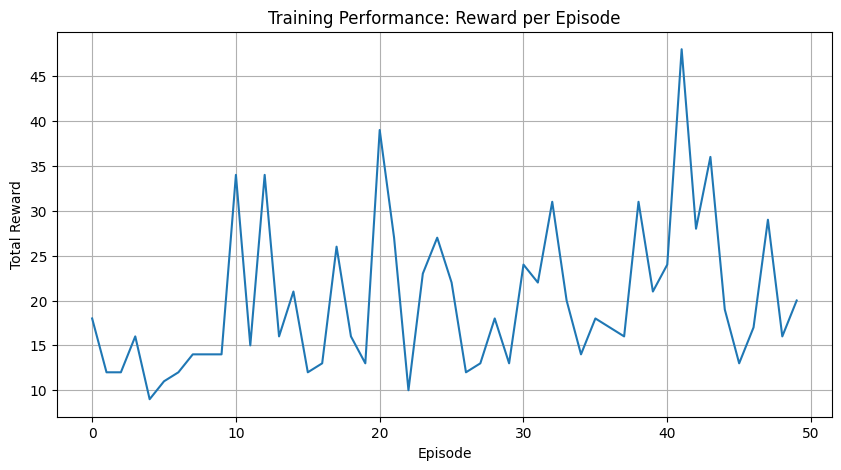


--- Episode 1 (Demonstration) ---
Step: 1, Action: 0, Reward: 1.0, State: [-0.00721164 -0.2162738   0.02223549  0.25941294]
Step: 2, Action: 0, Reward: 1.0, State: [-0.01153711 -0.411706    0.02742375  0.5590255 ]
Step: 3, Action: 0, Reward: 1.0, State: [-0.01977124 -0.60720193  0.03860426  0.86022073]
Step: 4, Action: 0, Reward: 1.0, State: [-0.03191527 -0.80282784  0.05580868  1.1647878 ]
Step: 5, Action: 0, Reward: 1.0, State: [-0.04797183 -0.99863005  0.07910443  1.4744331 ]
Step: 6, Action: 0, Reward: 1.0, State: [-0.06794443 -1.1946247   0.10859309  1.790738  ]
Step: 7, Action: 0, Reward: 1.0, State: [-0.09183692 -1.390784    0.14440785  2.1151075 ]
Step: 8, Action: 0, Reward: 1.0, State: [-0.11965261 -1.5870229   0.18671     2.4487104 ]
Step: 9, Action: 0, Reward: 1.0, State: [-0.15139306 -1.7831802   0.23568422  2.7924073 ]
Episode finished after 9 steps with reward: 9.0

--- Episode 2 (Demonstration) ---
Step: 1, Action: 0, Reward: 1.0, State: [ 0.00593038 -0.19268532 -0.0206

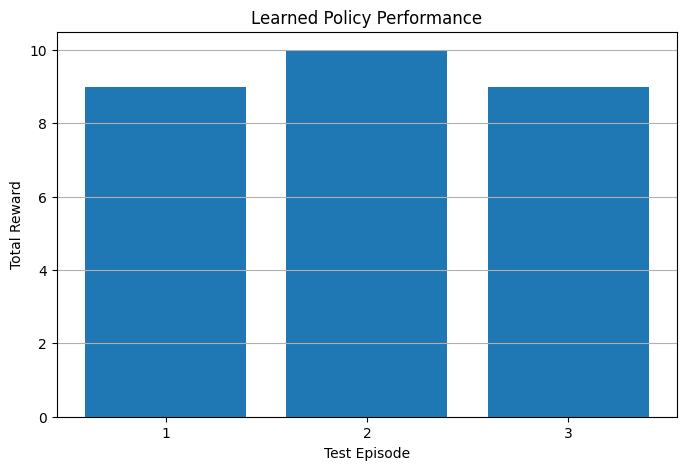

In [34]:
import gymnasium as gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Define the environment
env = gym.make('CartPole-v1')

# Define the state and action space
action_space = env.action_space.n

# Define the number of discrete states for each dimension
num_discrete_states = 10  # You can adjust this

# Initialize the Q-table with zeros
q_table = {}

# Define hyperparameters
learning_rate = 0.1
discount_factor = 0.99
exploration_rate = 1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.01
exploration_decay_rate = 0.001
num_episodes = 50
max_steps_per_episode = 500

# Function to discretize the continuous state space
def discretize_state(state, env, num_discrete_states=num_discrete_states):
    state_space_dim = env.observation_space.shape[0]
    discrete_state = []
    for i in range(state_space_dim):
        state_min = env.observation_space.low[i]
        state_max = env.observation_space.high[i]
        state_range = state_max - state_min
        if math.isnan(state_range) or state_range < 1e-10 or np.isnan(state[i]) \
          or np.isnan(state_min) or np.isnan(state_max) or np.isinf(state_range) \
          or np.isinf(state[i]) or np.isinf(state_min) or np.isinf(state_max):
            state_discrete = 0  # Assign a default value
        else:
            state_discrete = int(np.floor((state[i] - state_min) / state_range * num_discrete_states))
            state_discrete = min(max(0, state_discrete), num_discrete_states - 1)
        discrete_state.append(state_discrete)
    return tuple(discrete_state)

# Training the Q-learning agent
rewards_per_episode = []
for episode in range(num_episodes):
    state = env.reset()[0]
    state_discrete = discretize_state(state, env)
    total_reward = 0
    terminated = False
    truncated = False

    for step in range(max_steps_per_episode):
        # Exploration-exploitation trade-off
        if random.uniform(0, 1) > exploration_rate:
            if state_discrete not in q_table:
                q_table[state_discrete] = np.zeros(action_space)
            action = np.argmax(q_table[state_discrete])
        else:
            action = env.action_space.sample()

        new_state, reward, terminated, truncated, _ = env.step(action)
        new_state_discrete = discretize_state(new_state, env)
        total_reward += reward

        # Update the Q-table
        if state_discrete not in q_table:
            q_table[state_discrete] = np.zeros(action_space)
        if new_state_discrete not in q_table:
            q_table[new_state_discrete] = np.zeros(action_space)
        q_table[state_discrete][action] = q_table[state_discrete][action] + learning_rate * (
            reward + discount_factor * np.max(q_table[new_state_discrete]) - q_table[state_discrete][action]
        )

        state_discrete = new_state_discrete

        if terminated or truncated:
            break

    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(
        -exploration_decay_rate * episode
    )
    rewards_per_episode.append(total_reward)

print(f"Average reward over {num_episodes} episodes: {np.mean(rewards_per_episode)}")

# Visualize training performance
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance: Reward per Episode")
plt.grid(True)
plt.show()

# Demonstrate the learned policy (without exploration)
num_test_episodes = 3
policy_rewards = []
for episode in range(num_test_episodes):
    state = env.reset()[0]
    state_discrete = discretize_state(state, env)
    total_reward = 0
    terminated = False
    truncated = False
    episode_rewards = []
    print(f"\n--- Episode {episode + 1} (Demonstration) ---")
    for step in range(max_steps_per_episode):
        if state_discrete not in q_table:
            q_table[state_discrete] = np.zeros(action_space)
        action = np.argmax(q_table[state_discrete])
        new_state, reward, terminated, truncated, _ = env.step(action)
        new_state_discrete = discretize_state(new_state, env)
        total_reward += reward
        episode_rewards.append(reward)
        print(f"Step: {step + 1}, Action: {action}, Reward: {reward}, State: {new_state}")
        state_discrete = new_state_discrete
        if terminated or truncated:
            print(f"Episode finished after {step + 1} steps with reward: {total_reward}")
            break
    policy_rewards.append(total_reward)
env.close()

# Visualize learned policy performance
plt.figure(figsize=(8, 5))
plt.bar(range(1, num_test_episodes + 1), policy_rewards)
plt.xlabel("Test Episode")
plt.ylabel("Total Reward")
plt.title("Learned Policy Performance")
plt.xticks(range(1, num_test_episodes + 1))
plt.grid(axis='y')
plt.show()

Episode 1: Length = 18, Reward = 18.0
Episode 2: Length = 19, Reward = 19.0
Episode 3: Length = 20, Reward = 20.0
Episode 4: Length = 46, Reward = 46.0
Episode 5: Length = 12, Reward = 12.0
Episode 6: Length = 23, Reward = 23.0
Episode 7: Length = 33, Reward = 33.0
Episode 8: Length = 30, Reward = 30.0
Episode 9: Length = 19, Reward = 19.0
Episode 10: Length = 17, Reward = 17.0
Episode 11: Length = 10, Reward = 10.0
Episode 12: Length = 21, Reward = 21.0
Episode 13: Length = 35, Reward = 35.0
Episode 14: Length = 10, Reward = 10.0
Episode 15: Length = 21, Reward = 21.0


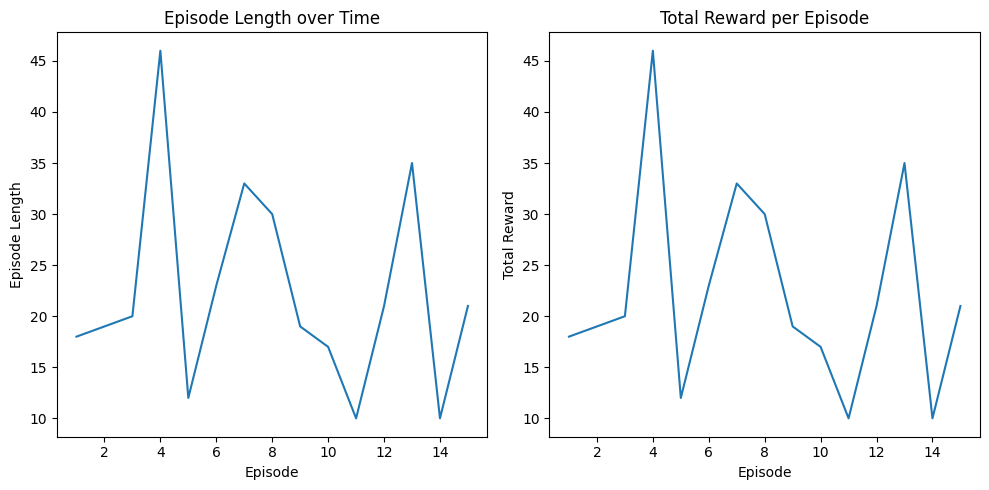

In [40]:
import gymnasium as gym
import time
import matplotlib.pyplot as plt
import numpy as np

# Define the environment
env = gym.make("CartPole-v1", render_mode="human")

# Define a simple random action agent
def random_policy(state):
    return env.action_space.sample()

# Set the number of episodes
num_episodes = 15

# Lists to store episode lengths and rewards for visualization
episode_lengths = []
episode_rewards = []

# Run the simulation
for episode in range(num_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    t = 0

    while not done:
        action = random_policy(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state
        t += 1
        time.sleep(0.01) # Add a small delay for visualization

    episode_lengths.append(t)
    episode_rewards.append(total_reward)
    print(f"Episode {episode + 1}: Length = {t}, Reward = {total_reward}")

# Close the environment
env.close()

# Visualization of episode lengths
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_episodes + 1), episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Length over Time")

# Visualization of episode rewards
plt.subplot(1, 2, 2)
plt.plot(range(1, num_episodes + 1), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")

plt.tight_layout()
plt.show()

# Exercise 2: Markov Decision Process (MDP)

A MDP provides a mathematical framework for modeling sequential decision-making in environments where the outcomes are partly random and partly under the control of a decision-maker, often referred to as an agent. It formally defines an environment for reinforcement learning, specifying how an agent interacts with this environment over time.

An MDP is characterized by five core elements: a set of states (S), a set of actions (A), a transition probability function (P), a reward function (R), and a discount factor (γ).

A directed graph is ploted using Python code with:
* The circles represent the states (S1, S2, S3, S4).
* The arrows represent the possible transitions between states.
* The labels on the edges indicate the action (red), the transition probability (green, denoted as 'P='), and the reward (blue, denoted as 'R=') associated with that transition.
* The discount factor (γ) is displayed as text on the plot.



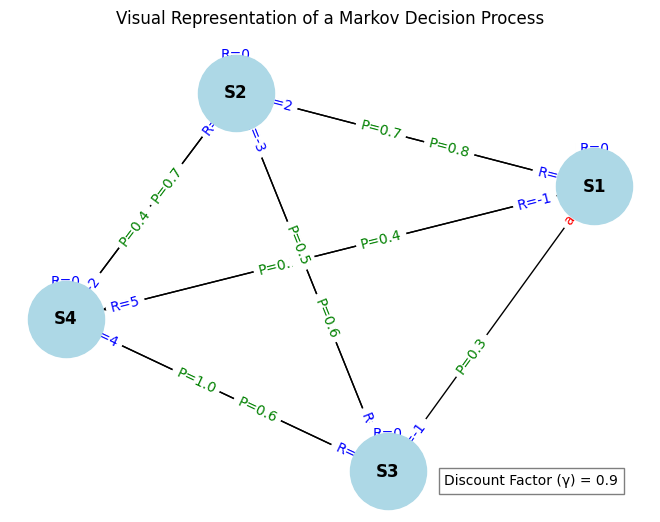

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the states
states = ['S1', 'S2', 'S3', 'S4']

# Define the actions available (for simplicity, assume the same actions are available in all states)
actions = ['a', 'b']

# Define the transition probabilities (example)
transition_probabilities = {
    ('S1', 'a', 'S2'): 0.7,
    ('S1', 'a', 'S3'): 0.3,
    ('S1', 'b', 'S1'): 0.9,
    ('S1', 'b', 'S4'): 0.1,
    ('S2', 'a', 'S3'): 0.6,
    ('S2', 'a', 'S4'): 0.4,
    ('S2', 'b', 'S2'): 0.2,
    ('S2', 'b', 'S1'): 0.8,
    ('S3', 'a', 'S4'): 1.0,
    ('S3', 'b', 'S2'): 0.5,
    ('S3', 'b', 'S3'): 0.5,
    ('S4', 'a', 'S1'): 0.4,
    ('S4', 'a', 'S3'): 0.6,
    ('S4', 'b', 'S4'): 0.3,
    ('S4', 'b', 'S2'): 0.7,
}

# Define the rewards (example)
rewards = {
    ('S1', 'a', 'S2'): 2,
    ('S1', 'a', 'S3'): -1,
    ('S1', 'b', 'S1'): 0,
    ('S1', 'b', 'S4'): 5,
    ('S2', 'a', 'S3'): 1,
    ('S2', 'a', 'S4'): -2,
    ('S2', 'b', 'S2'): 0,
    ('S2', 'b', 'S1'): 3,
    ('S3', 'a', 'S4'): 4,
    ('S3', 'b', 'S2'): -3,
    ('S3', 'b', 'S3'): 0,
    ('S4', 'a', 'S1'): -1,
    ('S4', 'a', 'S3'): 2,
    ('S4', 'b', 'S4'): 0,
    ('S4', 'b', 'S2'): 1,
}

# Define the discount factor (gamma)
gamma = 0.9

# Create a directed graph
graph = nx.DiGraph()

# Add nodes (states)
graph.add_nodes_from(states)

# Add edges (transitions with actions, probabilities, and rewards)
for (s, a, s_next), prob in transition_probabilities.items():
    reward = rewards.get((s, a, s_next), 0)
    graph.add_edge(s, s_next, action=a, probability=f'P={prob:.1f}', reward=f'R={reward}')

# Define layout for the graph
pos = nx.spring_layout(graph)

# Draw the nodes
nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, font_weight='bold')

# Draw the edges with action labels
edge_labels_action = {(u, v): d['action'] for u, v, d in graph.edges(data=True)}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels_action, font_color='red', label_pos=0.1)

# Draw the edge probabilities
edge_labels_prob = {(u, v): d['probability'] for u, v, d in graph.edges(data=True)}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels_prob, font_color='green', label_pos=0.6)

# Draw the edge rewards
edge_labels_reward = {(u, v): d['reward'] for u, v, d in graph.edges(data=True)}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels_reward, font_color='blue', label_pos=0.9)

# Add a text annotation for the discount factor
plt.text(0.95, 0.05, f'Discount Factor (γ) = {gamma}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# Set plot title
plt.title("Visual Representation of a Markov Decision Process")

# Show the plot
plt.show()

# Exercise 3: How the Markov property ensures that state transitions in an MDP?

The cornerstone of a Markov Decision Process (MDP) lies in its adherence to the Markov property, a fundamental characteristic that significantly simplifies the modeling and analysis of sequential decision-making problems. The Markov property, in essence, posits that the future state of the environment is conditionally independent of the past given the present state and the action taken. Formally, for a sequence of states $S_1,S_2,S_3,…$ and a sequence of actions $A_1,A_2,A_3,…,$ the transition probability from a current state $S_t$ to a future state $S_{t+1}$ upon taking an action $A_t$ is solely determined by $S_t$ and $A_t$, and is independent of the history of preceding states and actions $(S_1,A_1,S_2,A_2,…,S_{t-1},A_{t-1})$. This can be expressed mathematically as:
$P(S_{t+1}=s' | S_t=s, A_t=a, S_{t-1}=s_{t-1}, A_{t−1}=a_{t−1​},…,S_1=s_1,A_1=a_1)$ = $P(S_{t+1}=s'$ | $S_t =s,A_t =a)$

This equation articulates that the probability of transitioning to a specific next state s' at time t+1 is solely a function of the state s at the current time t and the action a taken at that time. The entire history leading up to the current state and action is rendered irrelevant for predicting the immediate future state.

The Markov property implies that the current state encapsulates all the necessary information from the past to make optimal future decisions. If the environment satisfies this property, the agent does not need to maintain a memory of the entire history of interactions. Instead, the agent can base its decisions solely on the current state it observes. This drastically reduces the complexity of the problem, as the state space becomes the primary focus for policy development and value function estimation.


##Case study: Imagine navigating a maze.

Suppose that the maze has the Markov property, then your next location depends only on your current location and the direction you choose to move. It doesn't matter how you arrived at your current location; the possible next locations and the likelihood of reaching them are the same regardless of your past path.

In the context of an MDP, the transition probability function $P(s'|s,a)$ embodies the Markov property. This function completely defines the dynamics of the environment by specifying the probability of transitioning to every possible next state s' from the current state s when action a is taken. The reward function $R(s,a,s')$ also typically adheres to this principle, where the immediate reward received depends on the current state, the action taken, and the resulting next state, without direct dependence on the prior history.

By adhering to the Markov property, MDPs provide a tractable framework for solving reinforcement learning problems. Algorithms like dynamic programming (e.g., value iteration, policy iteration) and temporal difference learning (e.g., Q-learning, SARSA) leverage this property to efficiently learn optimal policies by focusing on the state-action space without the need to consider the potentially infinite space of historical trajectories.

In [37]:
import numpy as np
import random

# Define the environment as a dictionary representing states, actions, transitions, and rewards
environment = {
    'S1': {'actions': {'a': [('S2', 0.7, 2), ('S3', 0.3, -1)],
                       'b': [('S1', 0.9, 0), ('S4', 0.1, 5)]}},
    'S2': {'actions': {'a': [('S3', 0.6, 1), ('S4', 0.4, -2)],
                       'b': [('S2', 0.2, 0), ('S1', 0.8, 3)]}},
    'S3': {'actions': {'a': [('S4', 1.0, 4)],
                       'b': [('S2', 0.5, -3), ('S3', 0.5, 0)]}},
    'S4': {'actions': {'a': [('S1', 0.4, -1), ('S3', 0.6, 2)],
                       'b': [('S4', 0.3, 0), ('S2', 0.7, 1)]}}
}

states = list(environment.keys())
actions_per_state = {s: list(environment[s]['actions'].keys()) for s in states}
gamma = 0.9
epsilon = 1e-6

# -------------------- Value Iteration --------------------
def value_iteration(env, gamma=0.9, epsilon=1e-6):
    V = {s: 0 for s in env}
    policy = {s: None for s in env}
    iteration = 0
    while True:
        iteration += 1
        V_old = V.copy()
        delta = 0
        for s in env:
            max_q = -np.inf
            best_action = None
            for a in env[s]['actions']:
                q_value = 0
                for next_s, prob, reward in env[s]['actions'][a]:
                    q_value += prob * (reward + gamma * V_old[next_s])
                if q_value > max_q:
                    max_q = q_value
                    best_action = a
            V[s] = max_q
            policy[s] = best_action
            delta = max(delta, abs(V[s] - V_old[s]))
        if delta < epsilon:
            break
    print("\n--- Value Iteration ---")
    print(f"Converged after {iteration} iterations.")
    print("Optimal Value Function (V):")
    for s in V:
        print(f"{s}: {V[s]:.4f}")
    print("Optimal Policy:")
    for s in policy:
        print(f"{s}: {policy[s]}")
    return policy, V

# -------------------- Policy Iteration --------------------
def policy_iteration(env, gamma=0.9, epsilon=1e-6):
    policy = {s: np.random.choice(list(env[s]['actions'].keys())) for s in env}
    V = {s: 0 for s in env}
    iteration = 0
    while True:
        iteration += 1
        # Policy Evaluation
        while True:
            V_old = V.copy()
            delta = 0
            for s in env:
                a = policy[s]
                v_new = 0
                for next_s, prob, reward in env[s]['actions'][a]:
                    v_new += prob * (reward + gamma * V_old[next_s])
                V[s] = v_new
                delta = max(delta, abs(V[s] - V_old[s]))
            if delta < epsilon:
                break

        # Policy Improvement
        policy_stable = True
        for s in env:
            old_action = policy[s]
            best_action = None
            max_q = -np.inf
            for a in env[s]['actions']:
                q_value = 0
                for next_s, prob, reward in env[s]['actions'][a]:
                    q_value += prob * (reward + gamma * V[next_s])
                if q_value > max_q:
                    max_q = q_value
                    best_action = a
            policy[s] = best_action
            if policy[s] != old_action:
                policy_stable = False

        if policy_stable:
            break

    print("\n--- Policy Iteration ---")
    print(f"Converged after {iteration} iterations.")
    print("Optimal Value Function (V):")
    for s in V:
        print(f"{s}: {V[s]:.4f}")
    print("Optimal Policy:")
    for s in policy:
        print(f"{s}: {policy[s]}")
    return policy, V

# -------------------- Q-Learning (Tabular) --------------------
def q_learning(env, gamma=0.9, learning_rate=0.1, epsilon=0.1, num_episodes=1000):
    Q = {s: {a: 0 for a in env[s]['actions']} for s in env}
    policy = {s: None for s in env}

    for episode in range(num_episodes):
        current_state = np.random.choice(states)
        terminated = False
        truncated = False  # Not applicable in this deterministic environment for simplicity

        while not terminated and not truncated:
            if np.random.rand() < epsilon:
                action = np.random.choice(list(env[current_state]['actions'].keys())) # Exploration
            else:
                action = max(Q[current_state], key=Q[current_state].get) # Exploitation

            possible_transitions = env[current_state]['actions'][action]
            if possible_transitions:
                index = np.random.choice(len(possible_transitions), p=[prob for _, prob, _ in possible_transitions])
                next_state, reward = possible_transitions[index][0], possible_transitions[index][2]

                # Q-learning update rule
                best_next_q = max(Q[next_state].values()) if next_state in Q else 0
                Q[current_state][action] = Q[current_state][action] + learning_rate * (
                    reward + gamma * best_next_q - Q[current_state][action]
                )
                current_state = next_state
            else:
                terminated = True # Should not happen in this defined environment

            # For simplicity, we'll consider an episode done after one step in this deterministic setting
            terminated = True

    # Extract policy from learned Q-values
    for s in env:
        if Q[s]:
            policy[s] = max(Q[s], key=Q[s].get)

    print("\n--- Q-Learning ---")
    print(f"Trained over {num_episodes} episodes.")
    print("Learned Q-values:")
    for s in Q:
        print(f"{s}: {Q[s]}")
    print("Learned Policy:")
    for s in policy:
        print(f"{s}: {policy[s]}")
    return policy, {s: max(Q[s].values()) if Q[s] else 0 for s in env}

# -------------------- SARSA --------------------
def sarsa(env, gamma=0.9, learning_rate=0.1, epsilon=0.1, num_episodes=1000):
    Q = {s: {a: 0 for a in env[s]['actions']} for s in env}
    policy = {s: None for s in env}
    states = list(env.keys())

    for episode in range(num_episodes):
        current_state = random.choice(states)

        # Epsilon-greedy action selection for the initial state
        if np.random.uniform(0, 1) < epsilon:
            current_action = random.choice(list(env[current_state]['actions'].keys()))
        else:
            current_action = max(Q[current_state], key=Q[current_state].get) if env[current_state]['actions'] else None

        terminated = False
        truncated = False  # Not strictly applicable in this example

        while not terminated and not truncated and current_action is not None:
            possible_transitions = env[current_state]['actions'][current_action]
            if possible_transitions:
                index = random.choices(range(len(possible_transitions)), weights=[prob for _, prob, _ in possible_transitions], k=1)[0]
                next_state, reward = possible_transitions[index][0], possible_transitions[index][2]

                # Epsilon-greedy action selection for the next state
                if random.uniform(0, 1) < epsilon:
                    next_action = random.choice(list(env[next_state]['actions'].keys()))
                else:
                    next_action = max(Q[next_state], key=Q[next_state].get) if env[next_state]['actions'] else None

                if next_action is not None:
                    # SARSA update rule
                    Q[current_state][current_action] = Q[current_state][current_action] + learning_rate * (
                        reward + gamma * Q[next_state][next_action] - Q[current_state][current_action]
                    )

                    current_state = next_state
                    current_action = next_action
                else:
                    terminated = True # No actions available in the next state
            else:
                terminated = True # No transitions for the current action

            # For simplicity, let's consider each step as the end of an "episode"
            # in this deterministic-within-action environment for demonstration.
            terminated = True

    # Extract policy from learned Q-values (greedy policy)
    for s in env:
        if env[s]['actions']:
            policy[s] = max(Q[s], key=Q[s].get)
        else:
            policy[s] = None

    print("\n--- SARSA ---")
    print(f"Trained over {num_episodes} episodes.")
    print("Learned Q-values:")
    for s in Q:
        print(f"{s}: {Q[s]}")
    print("Learned Policy:")
    for s in policy:
        print(f"{s}: {policy[s]}")

    return Q, policy


# Run the algorithms
value_iteration_policy, value_iteration_V = value_iteration(environment)
policy_iteration_policy, policy_iteration_V = policy_iteration(environment)
q_learning_policy, q_learning_V = q_learning(environment)
learned_Q_sarsa, learned_policy_sarsa = sarsa(environment)


--- Value Iteration ---
Converged after 139 iterations.
Optimal Value Function (V):
S1: 19.6045
S2: 20.1405
S3: 21.5406
S4: 19.4895
Optimal Policy:
S1: a
S2: b
S3: a
S4: a

--- Policy Iteration ---
Converged after 3 iterations.
Optimal Value Function (V):
S1: 19.6045
S2: 20.1405
S3: 21.5406
S4: 19.4895
Optimal Policy:
S1: a
S2: b
S3: a
S4: a

--- Q-Learning ---
Trained over 1000 episodes.
Learned Q-values:
S1: {'a': 17.04081480243662, 'b': 10.278777147779156}
S2: {'a': 7.170915273153549, 'b': 17.66104475760379}
S3: {'a': 18.24260827345475, 'b': 8.408761669582884}
S4: {'a': 9.187445658531308, 'b': 15.94873722940489}
Learned Policy:
S1: a
S2: b
S3: a
S4: b

--- SARSA ---
Trained over 1000 episodes.
Learned Q-values:
S1: {'a': 14.055794662702656, 'b': 4.5844292010412495}
S2: {'a': 6.579097536138994, 'b': 14.114343651866875}
S3: {'a': 16.59253108943895, 'b': 7.095758626209685}
S4: {'a': 14.06684993727816, 'b': 4.468557722135019}
Learned Policy:
S1: a
S2: b
S3: a
S4: a


How these algorithms leverage the Markov Property:

* Value Iteration and Policy Iteration: These dynamic programming algorithms rely heavily on the Markov property. The Bellman equations used in these algorithms assume that the future value of a state depends only on the current state and the action taken, and not on the history of how that state was reached. The transition probabilities $P(s'|s,a)$ encapsulate this Markovian nature. The algorithms iteratively update value functions and policies based solely on the immediate next states and rewards, without needing to consider entire historical trajectories.
* Q-Learning: Q-learning, a temporal difference learning algorithm, also benefits from the Markov property. The Q-value update rule:
$Q(s, a) \leftarrow Q(s, a) + \alpha [R(s, a, s') + \gamma \max_{a'} Q(s', a') - Q(s, a)]$
* SARSA (State-Action-Reward-State-Action): It updates its Q-value estimate for a state-action pair $(S_t, A_t)$ at time $t$ based on the immediate reward $R_{t+1}$ received after taking action $A_t$ in state $S_t$, and the Q-value of the subsequent state-action pair $(S_{t+1}, A_{t+1})$ at time $t+1$. The mathematical update rule for SARSA is given by:
$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)]$,  where:
   * $Q(S_t, A_t)$ is the current Q-value for the state $S_t$ and action $A_t$.
   * $\alpha$ (alpha) is the learning rate (a value between 0 and 1), which determines the extent to which the newly acquired information overrides the old value. A high learning rate makes the agent learn faster but can lead to instability.
   * $R_{t+1}$ is the reward received after taking action $A_t$ in state $S_t$ and transitioning to state $S_{t+1}$.
   * $\gamma$ (gamma) is the discount factor (a value between 0 and 1), which determines the importance of future rewards. A value close to 0 makes the agent short-sighted, considering only immediate rewards, while a value close to 1 makes it consider long-term rewards.
   * $Q(S_{t+1}, A_{t+1})$ is the Q-value of the next state $S_{t+1}$ and the action $A_{t+1}$ that was *actually taken* in that next state according to the agent's policy. This is a key characteristic of SARSA as an on-policy algorithm.
   * In essence, the SARSA update rule adjusts the Q-value of the previous state-action pair by considering the immediate reward and the expected future reward (discounted Q-value of the next state-action pair). The difference between the target value ($R_{t+1} + \gamma Q(S_{t+1}, A_{t+1})$) and the current Q-value ($Q(S_t, A_t)$) is the temporal difference (TD) error, which is scaled by the learning rate $\alpha$ to update the Q-value.



# Exercise 4: How does the Markov property help decision-making in RL?

The Markov property, a fundamental characteristic of Markov Decision Processes (MDPs), plays a pivotal role in simplifying the decision-making process within RL. By ensuring that future states depend solely on the current state and the action taken, it drastically reduces the complexity of the problem space that an RL agent needs to consider. This simplification allows for the development of tractable and efficient algorithms for learning optimal policies. Let's explore this significance through illustrative examples.

##Case Study:
Consider an agent navigating a simple 3x3 grid world. The agent can move in four directions: North, South, East, or West. The goal is to reach a specific goal state while avoiding a penalty state.

* **Markovian Scenario:** If the environment is Markovian, the agent's next position depends only on its current position and the chosen action. For instance, if the agent is at cell (2, 2) and chooses to move North, the probability of ending up in cell (1, 2) is solely determined by this current state and action, regardless of the path taken to reach (2, 2). The reward received upon transitioning to the next state is also solely dependent on the current state, the action, and the next state. In this case, an RL agent can learn a value function for each state and a policy that maps each state to the optimal action by considering only the immediate consequences of its actions. Algorithms like Q-learning can efficiently build a Q-table where each entry $Q(s, a)$ represents the expected future reward starting from state $s$, taking action $a$, and following an optimal policy thereafter. The update rule for Q-learning, $Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]$, relies entirely on the current state $s$, the action $a$, the immediate reward $r$, and the next state $s'$. The history of previous states and actions is implicitly captured within the Q-value of the current state.

* **Non-Markovian Scenario:** Now, imagine if the environment were non-Markovian. For example, suppose the success of moving North from (2, 2) depended on the number of times the agent had previously moved East in the last three steps. In this case, the current state (2, 2) alone is insufficient to predict the outcome of the 'North' action. The agent would need to maintain a history of its past actions to make informed decisions. The state space would no longer be just the 9 cells of the grid but would expand to include the history of recent actions, making the problem significantly more complex. Standard RL algorithms designed for MDPs would struggle in such an environment without modifications to incorporate memory or a more complex state representation.



In [38]:
import numpy as np
import random

# Define the grid world environment
class GridWorld:
    def __init__(self, size=3, goal=(2, 2), penalty=(1, 1)):
        self.size = size
        self.goal = goal
        self.penalty = penalty
        self.agent_pos = (0, 0)
        self.actions = ['N', 'S', 'E', 'W']

    def is_valid(self, pos):
        return 0 <= pos[0] < self.size and 0 <= pos[1] < self.size

    def step(self, action):
        row, col = self.agent_pos
        if action == 'N': row -= 1
        elif action == 'S': row += 1
        elif action == 'E': col += 1
        elif action == 'W': col -= 1

        self.agent_pos = (row, col)
        if self.agent_pos == self.goal:
            return self.agent_pos, 10, True
        elif self.agent_pos == self.penalty:
            return self.agent_pos, -5, True
        elif not self.is_valid(self.agent_pos):
            self.agent_pos = (row + (row < 0) - (row >= self.size), col + (col < 0) - (col >= self.size)) # Stay in bounds
            return self.agent_pos, -1, False
        else:
            return self.agent_pos, -1, False

    def reset(self):
        self.agent_pos = (0, 0)
        return self.agent_pos

# Initialize environment and Q-table
env = GridWorld()
q_table = {}
for r in range(env.size):
    for c in range(env.size):
        q_table[(r, c)] = {a: 0 for a in env.actions}

# Q-learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
num_episodes = 1000

# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = random.choice(env.actions) # Explore
        else:
            action = max(env.actions, key=lambda a: q_table[state][a]) # Exploit

        next_state, reward, done = env.step(action)
        q_table[state][action] = q_table[state][action] + alpha * (reward + gamma * max(q_table[next_state].values()) - q_table[state][action])
        state = next_state

# Print learned Q-table
print("Learned Q-table:")
for s in q_table:
    print(f"{s}: {q_table[s]}")

# Extract and print the learned policy
policy = {}
for r in range(env.size):
    for c in range(env.size):
        policy[(r, c)] = max(env.actions, key=lambda a: q_table[(r, c)][a])
print("\nLearned Policy:")
for r in range(env.size):
    for c in range(env.size):
        print(f"State ({r}, {c}): {policy[(r, c)]}")

Learned Q-table:
(0, 0): {'N': 2.821543828312517, 'S': 1.0192176483448838, 'E': 4.579999999999986, 'W': 2.9133691716480214}
(0, 1): {'N': 4.249324644797716, 'S': -4.5568530940173755, 'E': 6.199999999999989, 'W': 2.9913286402891655}
(0, 2): {'N': 5.825047925275639, 'S': 7.999999999999991, 'E': 5.786004468542841, 'W': 4.228166482513201}
(1, 0): {'N': 2.893764009212503, 'S': -0.5577368475781, 'E': -0.95, 'W': -0.5031623609336761}
(1, 1): {'N': 0, 'S': 0, 'E': 0, 'W': 0}
(1, 2): {'N': 5.903231632086267, 'S': 9.999999999999993, 'E': 7.425681248789806, 'W': -3.7290670858354997}
(2, 0): {'N': -0.32258259100000003, 'S': -0.199, 'E': 1.3751096381, 'W': -0.2735929}
(2, 1): {'N': -0.5, 'S': 0.32257951100000004, 'E': 6.12579511, 'W': 0}
(2, 2): {'N': 0, 'S': 0, 'E': 0, 'W': 0}

Learned Policy:
State (0, 0): E
State (0, 1): E
State (0, 2): S
State (1, 0): N
State (1, 1): N
State (1, 2): S
State (2, 0): E
State (2, 1): E
State (2, 2): N


# Exercise 5: Lizard Game

Suppose that Lizard wants to eat as many grasshoppers as possible in the least amount of time without stumbling across a bird, which will, itself, eat the lizard.
- Lizard is the agent in this environment.
- Lizard’s actions which can move left, right, up, or down in this environment.
- States are determined by the individual tiles and where the lizard is on the board at any given time.




Reward Table R(s, a):
(1, 'down'): -1
(1, 'right'): 0
(2, 'left'): -1
(2, 'right'): -10
(2, 'down'): 1
(3, 'left'): 0
(3, 'down'): -1
(4, 'up'): -1
(4, 'right'): 1
(4, 'down'): 10
(5, 'up'): 1
(5, 'left'): -1
(5, 'right'): -1
(5, 'down'): -1
(6, 'up'): -10
(6, 'left'): 1
(6, 'down'): -1
(7, 'up'): -1
(7, 'right'): -1
(8, 'up'): 1
(8, 'left'): 10
(8, 'right'): -1
(9, 'up'): -1
(9, 'left'): -1
(1, 'up'): -1
(1, 'left'): -1
(2, 'up'): -1
(3, 'up'): -1
(3, 'right'): -1
(4, 'left'): -1
(6, 'right'): -1
(7, 'down'): -1
(7, 'left'): -1
(8, 'down'): -1
(9, 'down'): -1
(9, 'right'): -1


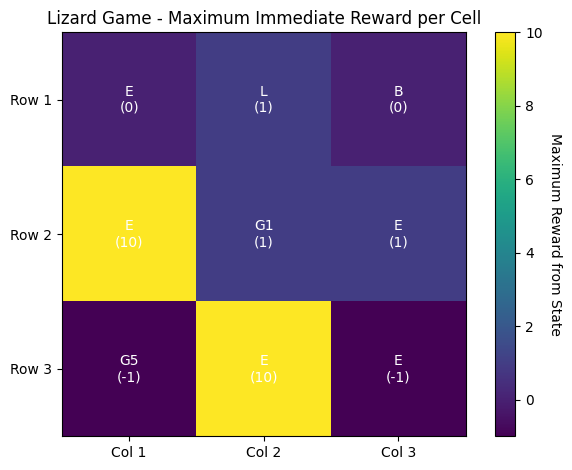

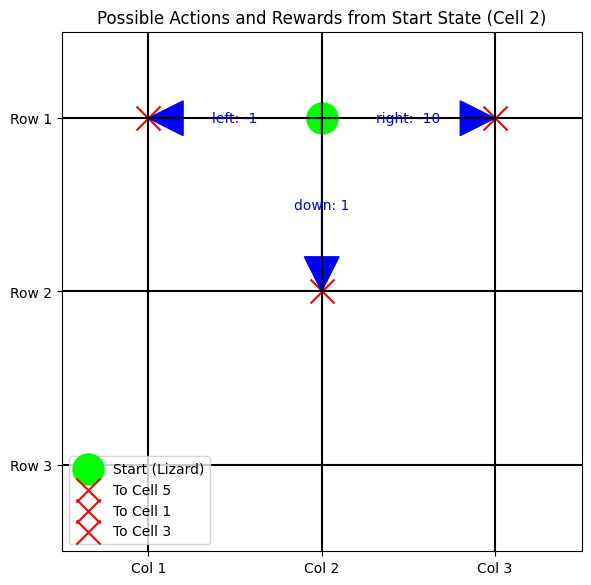

In [39]:
import matplotlib.pyplot as plt
import numpy as np

reward_table = {}

# Transitions and rewards based on the board
# (current_state, action) -> reward

# From Cell 1 (Empty)
reward_table[(1, 'down')] = -1  # To Cell 4 (Empty)
reward_table[(1, 'right')] = 0   # To Cell 2 (Lizard - Start, no inherent reward for landing)

# From Cell 2 (Lizard - Start)
reward_table[(2, 'left')] = -1   # To Cell 1 (Empty)
reward_table[(2, 'right')] = -10  # To Cell 3 (Bird - End)
reward_table[(2, 'down')] = 1    # To Cell 5 (1 Grasshopper)

# From Cell 3 (Bird - End) - No outgoing actions as episode ends
reward_table[(3, 'left')] = 0    # To Cell 2 (Lizard - Start, no inherent reward for landing)
reward_table[(3, 'down')] = -1   # To Cell 6 (Empty)

# From Cell 4 (Empty)
reward_table[(4, 'up')] = -1     # To Cell 1 (Empty)
reward_table[(4, 'right')] = 1    # To Cell 5 (1 Grasshopper)
reward_table[(4, 'down')] = 10   # To Cell 7 (5 Grasshoppers - End)

# From Cell 5 (1 Grasshopper)
reward_table[(5, 'up')] = 1      # To Cell 2 (Lizard - Start, no inherent reward for landing)
reward_table[(5, 'left')] = -1    # To Cell 4 (Empty)
reward_table[(5, 'right')] = -1   # To Cell 6 (Empty)
reward_table[(5, 'down')] = -1    # To Cell 8 (Empty)

# From Cell 6 (Empty)
reward_table[(6, 'up')] = -10    # To Cell 3 (Bird - End)
reward_table[(6, 'left')] = 1     # To Cell 5 (1 Grasshopper)
reward_table[(6, 'down')] = -1    # To Cell 9 (Empty)

# From Cell 7 (5 Grasshoppers - End) - No outgoing actions as episode ends
reward_table[(7, 'up')] = -1     # To Cell 4 (Empty)
reward_table[(7, 'right')] = -1   # To Cell 8 (Empty)

# From Cell 8 (Empty)
reward_table[(8, 'up')] = 1      # To Cell 5 (1 Grasshopper)
reward_table[(8, 'left')] = 10    # To Cell 7 (5 Grasshoppers - End)
reward_table[(8, 'right')] = -1   # To Cell 9 (Empty)

# From Cell 9 (Empty)
reward_table[(9, 'up')] = -1     # To Cell 6 (Empty)
reward_table[(9, 'left')] = -1    # To Cell 8 (Empty)

# Handle cases where movement is off the board (implicitly a terminal or no-change state with a potential penalty)
for state in range(1, 10):
    if state in [1, 2, 3]: # Top row
        if (state, 'up') not in reward_table:
            reward_table[(state, 'up')] = -1 # Stay in place or terminal with penalty
    if state in [7, 8, 9]: # Bottom row
        if (state, 'down') not in reward_table:
            reward_table[(state, 'down')] = -1 # Stay in place or terminal with penalty
    if state in [1, 4, 7]: # Left column
        if (state, 'left') not in reward_table:
            reward_table[(state, 'left')] = -1 # Stay in place or terminal with penalty
    if state in [3, 6, 9]: # Right column
        if (state, 'right') not in reward_table:
            reward_table[(state, 'right')] = -1 # Stay in place or terminal with penalty

# Ensure all state-action pairs for valid moves within the board are covered
possible_moves = {
    1: {'down': 4, 'right': 2},
    2: {'left': 1, 'right': 3, 'down': 5},
    3: {'left': 2, 'down': 6},
    4: {'up': 1, 'right': 5, 'down': 7},
    5: {'up': 2, 'left': 4, 'right': 6, 'down': 8},
    6: {'up': 3, 'left': 5, 'down': 9},
    7: {'up': 4, 'right': 8},
    8: {'up': 5, 'left': 7, 'right': 9},
    9: {'up': 6, 'left': 8}
}

for s in range(1, 10):
    for action in ['up', 'down', 'left', 'right']:
        if (s, action) not in reward_table:
            if s in possible_moves and action in possible_moves[s]:
                next_s = possible_moves[s][action]
                if next_s == 1 or next_s == 4 or next_s == 6 or next_s == 8 or next_s == 9:
                    reward_table[(s, action)] = -1
                elif next_s == 5:
                    reward_table[(s, action)] = 1
                elif next_s == 3:
                    reward_table[(s, action)] = -10
                elif next_s == 7:
                    reward_table[(s, action)] = 10
            else:
                reward_table[(s, action)] = -1 # Default penalty for invalid move/off-board

print("Reward Table R(s, a):")
for key, value in reward_table.items():
    print(f"({key[0]}, '{key[1]}'): {value}")

# Visualize the reward table as a heatmap
board = np.zeros((3, 3))
annotations = np.full((3, 3), '', dtype=object)
rewards_grid = np.zeros((3, 3))

mapping = {1: (0, 0), 2: (0, 1), 3: (0, 2),
           4: (1, 0), 5: (1, 1), 6: (1, 2),
           7: (2, 0), 8: (2, 1), 9: (2, 2)}

content = {1: 'E', 2: 'L', 3: 'B',
           4: 'E', 5: 'G1', 6: 'E',
           7: 'G5', 8: 'E', 9: 'E'}

reward_values = {}
for s in range(1, 10):
    max_reward = -np.inf
    for action in ['up', 'down', 'left', 'right']:
        if (s, action) in reward_table:
            max_reward = max(max_reward, reward_table[(s, action)])
    reward_values[s] = max_reward if max_reward != -np.inf else 0

for s, (r, c) in mapping.items():
    rewards_grid[r, c] = reward_values[s]
    annotations[r, c] = f"{content[s]}\n({rewards_grid[r, c]:.0f})"

fig, ax = plt.subplots()
im = ax.imshow(rewards_grid, cmap='viridis')

# Add annotations
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, annotations[i, j], ha="center", va="center", color="w")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Maximum Reward from State", rotation=-90, va="bottom")

# Set ticks and labels
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['Col 1', 'Col 2', 'Col 3'])
ax.set_yticklabels(['Row 1', 'Row 2', 'Row 3'])

# Title
ax.set_title("Lizard Game - Maximum Immediate Reward per Cell")
fig.tight_layout()
plt.show()

# Visualize specific transitions from the start state (Cell 2)
start_state = 2
start_row, start_col = mapping[start_state]
actions_from_start = {'up': (start_row - 1, start_col),
                      'down': (start_row + 1, start_col),
                      'left': (start_row, start_col - 1),
                      'right': (start_row, start_col + 1)}

plt.figure(figsize=(6, 6))
plt.imshow(np.zeros((3, 3)), cmap='gray_r', alpha=0.3) # Background
plt.xticks(np.arange(3))
plt.yticks(np.arange(3))
plt.grid(which='both', color='black', linewidth=1.5)
ax = plt.gca()
ax.set_xticklabels(['Col 1', 'Col 2', 'Col 3'])
ax.set_yticklabels(['Row 1', 'Row 2', 'Row 3'])

# Mark the start state
plt.scatter(start_col, start_row, color='lime', s=500, marker='o', label=f'Start (Lizard)')

for action, (r, c) in actions_from_start.items():
    if 0 <= r < 3 and 0 <= c < 3:
        next_state = [k for k, v in mapping.items() if v == (r, c)][0]
        reward = reward_table.get((start_state, action), -1) # Get reward, default -1
        plt.scatter(c, r, color='red', s=300, marker='x', label=f'To Cell {next_state}')
        plt.arrow(start_col, start_row, c - start_col, r - start_row, head_width=0.2, head_length=0.2, fc='blue', ec='blue', length_includes_head=True)
        plt.text((start_col + c) / 2, (start_row + r) / 2, f'{action}: {reward}', color='blue', fontsize=10, ha='center', va='center')

plt.title(f"Possible Actions and Rewards from Start State (Cell {start_state})")
plt.legend()
plt.tight_layout()
plt.show()